# Battle of the Neighborhoods

Mission Statement: You are a chef are looking to move to a new city with your family. Armed with a passion for multicultural foods, you want to settle into a busy city to open up a restaurant. 

### You want to know -- which city should you move to and what type of food should you make? You will use the following information:  
- the diversity of food
    - As a chef, you want to enter an area with LOW diversity. This would mean that your restaurant would be the only of its type in the region and would thus be popular
- The price distribution for restaurants in general
    - You want to make money... Family to support!
- The price ranges for different food types in a city
    - For example, fish restaurants might be the most expensive option in St. Loius but the cheapest in Boston. Ramen restaurants may ALWAYS tend to be the cheaper option and and the price ranges for a) restaurants in general and b) restaurant types
    - Understanding how cities vary in the "value" of food types will help you determine what TYPE of chef to become. 
    
An example conclusion from this notebook would be:   
- "The three cities with the least food diversity are New York, NY, Mongtomery Alabama, and Baltimore, MD. These would be great cities to introduce variety."
- "However, Montgomery food is generally cheap so I should to to New York or Baltimore to maximize my income. Both of these cities have very few Korean restaurants."
- "However, those in New York fetch a much higher price. As such, I should move to New York (since it is non-diverse in venues and I can charge high) and I should make Korean food since there is a gap in the market and I can charge high."

"If I cant find a place to stay in New York, I should travel to Baltimore or Chicago which are very similar food cities."   



### Imports

In [2]:
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import preprocessing
import json 

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
# from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
# from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import warnings #silence depreciation warnings for below graphs
warnings.simplefilter('ignore')

#!conda install -c conda-forge folium=0.5.0 --yes #uncomment this if pywaffle errors out
import pywaffle
from pywaffle import Waffle

import glob

# Data Collection and Analysis Workflow

1) Initialize Foursquare
2) Read in the foursquare data into a csvs for each city and price range  
2) Convert csvs to pandas dataframes  
3) Merge the dataframes into a "total" dataframe  
4) Make a city dataframe containing info  on each unique city. Ex.  lat, long, counts of each price, price distribution, averge price, and the number of unique venue categories  
5) Make a venue dataframe containing info on each unique  venue category. Ex. prevalance, average price  
6) Compute analysis on the cities. Compute diversity score and average prices. Then weight the two of them (user can input weights) to produce a recommendation score   
7) Derive final conclusions

## Initialize for Foursquare  

According to Wiki, Foursquare is "a local search-and-discovery mobile app which provides search results for its users. The app provides personalized recommendations of places to go near a user's current location based on users' previous browsing history and check-in history."

We will use it to gather information on food venues in a city specified by latitude and longitude. General info here https://foursquare.com/ and developer info here https://developer.foursquare.com/ You will need your own IDs and keys (recommended to make a sandbox account)

In [1]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
CATEGORY_ID = '4d4b7105d754a06374d81259'
LIMIT = 300 #max. results to return with queries 
radius = 3000 #how far from a user-specified lat/long to look
CATEGORY_ID = '4d4b7105d754a06374d81259' #Food category for venues

Note: Foursquare has imitations on the number of API calls per hour
They also have a limit to the number of premium vs regular calls 
My method does make a lot of csvs, but only to favor a method avoiding  premium calls 

##### Function Description:  
Inputs: city name and coordinates. Lat and long used to find venues, filtered for the food category .  
Results filtered by price. Price ranges are given by values 1-4. 1 is cheapest 4 is most expensive.

Thus, each city gets a total of 4 dataframes. ex. Austin_1 is for the cheap restaurants. Austin_2_3_4 also exist and are written to csvs. Foursquare limits the number of API calls, so the function checks to see if the csv already exists before proceeding. This is to make sure that you don't unnessesarily use up calls to use up the foresquare quota

Results: Returns a dataframe and saves the csv for each price/city

In [3]:
def getRestVenues(name, lat, lng, price):
    fpath = './' + str(name) + '_price_' + price + '_df.csv'
    try:
        fh = open(fpath, 'r')
        print(fpath + "file already exists")
    except FileNotFoundError:
        print('making new file for ' + name)
        venues_list=[]
        CITY = name
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&categoryId={}&ll={},{}&radius={}&price={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION,CATEGORY_ID,lat, lng, radius, price,LIMIT)

        results = requests.get(url).json()
        totalResultCount = results['response']['totalResults']
        results = results['response']['groups'][0]['items']

        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'], ) 
            for v in results])

        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['City', 
                      'City Latitude', 
                      'City Longitude', 
                      'Venue', 
                      'Venue Latitude', 
                      'Venue Longitude', 
                      'Venue Category']
        nearby_venues['Price'] = int(price)
        nearby_venues.to_csv(fpath)

        return(nearby_venues)

##### Initialize a list of cities, latitudes, and longitudes

In [4]:
## Get data for all the cities
city_list = ["Austin", 'DC', 'Orlando', "Boston", 'San_Fransicso', 'Seattle', 'St_Louis',' Atlanta', 
            'Paris', 'London', 'Ottawa', 'Las_Vegas', 'Nashville', 'Philadelphia',
            'Portland', 'LA', 'Chicago', 'Vienna', 'El_Paso']
lats = [30.287729, 38.905649, 28.541217, 42.344840, 37.776198, 47.617981, 38.611594, 33.775697, 
       48.876735, 51.515839, 45.411800, 36.117758, 36.161013, 39.951027, 
       45.5204589, 34.048628, 41.882194, 38.903798, 31.760006]
longs = [-97.731618, -77.028792,-81.371762, -71.080379, -122.417002,  -122.342832, -90.222135, -84.384971, 
        2.335686,  -0.123997, -75.696044, -115.169727, -86.782160, -75.164180, 
        -122.67802, -118.255580, -87.630320, -77.263692, -106.489637]

#### Make a function to introduce new cities

In [5]:
def add_city(city, lat, long):
    if city not in city_list:
        city_list.append(city)
        lats.append(lat)
        longs.append(long)
    else: print(city, 'has already been processed')
add_city('Honolulu', 21.308780, -157.860352)
add_city('Detroit', 42.336955, -83.052963)
add_city('Milwaukee', 43.041679, -87.911132)
add_city('Columbus', 39.960189, -82.997523)
add_city('Lousville', 38.251193, -85.759666)
add_city('Indianapolis', 39.768760, -86.156019)
add_city('Los Angeles', 34.050422, -118.248704)
add_city('Phoenix', 33.450548, -112.075848)
add_city('Charlotte', 35.227095, -80.842512)
add_city('Boston', 42.347176, -71.068817)
add_city('Denver', 39.743045, -104.983322)
add_city('Baltimore', 39.292396, -76.617572)
add_city('Miami', 25.767790, -80.199591)
add_city('Toronto', 43.651534, -79.385576)
add_city('Montreal', 45.499911, -73.562465)
add_city('Omaha', 41.256172, -95.939847)
add_city('Kanas_City', 39.101510, -94.584155)

Boston has already been processed


# Collecting the data  
Collecting the data from a Foursquare API call and putting into a pandas dataframe
Make a csv file for each city for each price range  

For example, DC_1 contains the city, city lat/long, venue, venue category, and price for each venue with price in range 1  
DC_2, 3, and 4 also exist. 

In order to avoid excessive API calls (these are limited in free account), make sure that you haven't already processed the file. If you have, the file exists, so the call is not made

In [6]:
error_list = []
for price in range(1,5):
    for i, city in enumerate(city_list):
        print(price, city, i)
        df_name = city.lower() +'_venues_' + str(price)
        print(df_name)
        lat = lats[i]
        long = longs[i]
        try: 
            atlanta_venues_1 = getRestVenues(name=city, price=str(price),lat=lat,lng=long)
        except:
            print('There was an error with ' + city + str(price))
            error_list.append(str(city + str(price)))
            continue       

1 Austin 0
austin_venues_1
./Austin_price_1_df.csvfile already exists
1 DC 1
dc_venues_1
./DC_price_1_df.csvfile already exists
1 Orlando 2
orlando_venues_1
./Orlando_price_1_df.csvfile already exists
1 Boston 3
boston_venues_1
./Boston_price_1_df.csvfile already exists
1 San_Fransicso 4
san_fransicso_venues_1
./San_Fransicso_price_1_df.csvfile already exists
1 Seattle 5
seattle_venues_1
./Seattle_price_1_df.csvfile already exists
1 St_Louis 6
st_louis_venues_1
./St_Louis_price_1_df.csvfile already exists
1  Atlanta 7
 atlanta_venues_1
./ Atlanta_price_1_df.csvfile already exists
1 Paris 8
paris_venues_1
./Paris_price_1_df.csvfile already exists
1 London 9
london_venues_1
./London_price_1_df.csvfile already exists
1 Ottawa 10
ottawa_venues_1
./Ottawa_price_1_df.csvfile already exists
1 Las_Vegas 11
las_vegas_venues_1
./Las_Vegas_price_1_df.csvfile already exists
1 Nashville 12
nashville_venues_1
./Nashville_price_1_df.csvfile already exists
1 Philadelphia 13
philadelphia_venues_1
./Phi

There was an error with Phoenix4
4 Charlotte 27
charlotte_venues_4
./Charlotte_price_4_df.csvfile already exists
4 Denver 28
denver_venues_4
./Denver_price_4_df.csvfile already exists
4 Baltimore 29
baltimore_venues_4
./Baltimore_price_4_df.csvfile already exists
4 Miami 30
miami_venues_4
./Miami_price_4_df.csvfile already exists
4 Toronto 31
toronto_venues_4
./Toronto_price_4_df.csvfile already exists
4 Montreal 32
montreal_venues_4
./Montreal_price_4_df.csvfile already exists
4 Omaha 33
omaha_venues_4
./Omaha_price_4_df.csvfile already exists
4 Kanas_City 34
kanas_city_venues_4
./Kanas_City_price_4_df.csvfile already exists


In [7]:
print(error_list)
print('These errored since there are no instances')

['Phoenix4']
These errored since there are no instances


In [8]:
dc1_df = pd.read_csv('./DC_price_1_df.csv')
dc1_df

Unnamed: 0 City  City Latitude  City Longitude  \
0            0   DC      38.905649      -77.028792   
1            1   DC      38.905649      -77.028792   
2            2   DC      38.905649      -77.028792   
3            3   DC      38.905649      -77.028792   
4            4   DC      38.905649      -77.028792   
5            5   DC      38.905649      -77.028792   
6            6   DC      38.905649      -77.028792   
7            7   DC      38.905649      -77.028792   
8            8   DC      38.905649      -77.028792   
9            9   DC      38.905649      -77.028792   
10          10   DC      38.905649      -77.028792   
11          11   DC      38.905649      -77.028792   
12          12   DC      38.905649      -77.028792   
13          13   DC      38.905649      -77.028792   
14          14   DC      38.905649      -77.028792   
15          15   DC      38.905649      -77.028792   
16          16   DC      38.905649      -77.028792   
17          17   DC      38.905649      -77.028792   
18          18   DC      38.905649      -77.028792   
19          19   DC      38.905649      -77.028792   
20          20   DC      38.905649      -77.028792   
21          21   DC      38.905649      -77.028792   
22          22   DC      38.905649      -77.028792   
23          23   DC      38.905649      -77.028792   
24          24   DC      38.905649      -77.028792   
25          25   DC      38.905649      -77.028792   
26          26   DC      38.905649      -77.028792   
27          27   DC      38.905649      -77.028792   
28          28   DC      38.905649      -77.028792   
29          29   DC      38.905649      -77.028792   
30          30   DC      38.905649      -77.028792   
31          31   DC      38.905649      -77.028792   
32          32   DC      38.905649      -77.028792   
33          33   DC      38.905649      -77.028792   
34          34   DC      38.905649      -77.028792   
35          35   DC      38.905649      -77.028792   
36          36   DC      38.905649      -77.028792   
37          37   DC      38.905649      -77.028792   
38          38   DC      38.905649      -77.028792   
39          39   DC      38.905649      -77.028792   
40          40   DC      38.905649      -77.028792   
41          41   DC      38.905649      -77.028792   
42          42   DC      38.905649      -77.028792   
43          43   DC      38.905649      -77.028792   
44          44   DC      38.905649      -77.028792   
45          45   DC      38.905649      -77.028792   
46          46   DC      38.905649      -77.028792   
47          47   DC      38.905649      -77.028792   
48          48   DC      38.905649      -77.028792   
49          49   DC      38.905649      -77.028792   
50          50   DC      38.905649      -77.028792   
51          51   DC      38.905649      -77.028792   
52          52   DC      38.905649      -77.028792   
53          53   DC      38.905649      -77.028792   
54          54   DC      38.905649      -77.028792   
55          55   DC      38.905649      -77.028792   
56          56   DC      38.905649      -77.028792   
57          57   DC      38.905649      -77.028792   
58          58   DC      38.905649      -77.028792   
59          59   DC      38.905649      -77.028792   
60          60   DC      38.905649      -77.028792   
61          61   DC      38.905649      -77.028792   
62          62   DC      38.905649      -77.028792   
63          63   DC      38.905649      -77.028792   
64          64   DC      38.905649      -77.028792   
65          65   DC      38.905649      -77.028792   
66          66   DC      38.905649      -77.028792   
67          67   DC      38.905649      -77.028792   
68          68   DC      38.905649      -77.028792   
69          69   DC      38.905649      -77.028792   
70          70   DC      38.905649      -77.028792   
71          71   DC      38.905649      -77.028792   
72          72   DC      38.905649      -77.028792   
73      

Combine all of the city and price dfs into one comprehensive dataframe. Save this dataframe for ease of use later

In [9]:
total_df = pd.concat([pd.read_csv(f) for f in glob.glob('*_df.csv')], ignore_index = True)

In [10]:
total_df.drop('Unnamed: 0', axis=1, inplace=True)
total_df.to_csv('./total_df_all_prices.csv')
total_df

City  City Latitude  City Longitude  \
0       Los Angeles      34.050422     -118.248704   
1       Los Angeles      34.050422     -118.248704   
2       Los Angeles      34.050422     -118.248704   
3       Los Angeles      34.050422     -118.248704   
4       Los Angeles      34.050422     -118.248704   
5       Los Angeles      34.050422     -118.248704   
6       Los Angeles      34.050422     -118.248704   
7       Los Angeles      34.050422     -118.248704   
8       Los Angeles      34.050422     -118.248704   
9       Los Angeles      34.050422     -118.248704   
10      Los Angeles      34.050422     -118.248704   
11      Los Angeles      34.050422     -118.248704   
12      Los Angeles      34.050422     -118.248704   
13      Los Angeles      34.050422     -118.248704   
14      Los Angeles      34.050422     -118.248704   
15      Los Angeles      34.050422     -118.248704   
16      Los Angeles      34.050422     -118.248704   
17      Los Angeles      34.050422     -118.248704   
18      Los Angeles      34.050422     -118.248704   
19      Los Angeles      34.050422     -118.248704   
20      Los Angeles      34.050422     -118.248704   
21      Los Angeles      34.050422     -118.248704   
22      Los Angeles      34.050422     -118.248704   
23      Los Angeles      34.050422     -118.248704   
24      Los Angeles      34.050422     -118.248704   
25      Los Angeles      34.050422     -118.248704   
26      Los Angeles      34.050422     -118.248704   
27      Los Angeles      34.050422     -118.248704   
28      Los Angeles      34.050422     -118.248704   
29      Los Angeles      34.050422     -118.248704   
30      Los Angeles      34.050422     -118.248704   
31      Los Angeles      34.050422     -118.248704   
32      Los Angeles      34.050422     -118.248704   
33      Los Angeles      34.050422     -118.248704   
34      Los Angeles      34.050422     -118.248704   
35      Los Angeles      34.050422     -118.248704   
36      Los Angeles      34.050422     -118.248704   
37      Los Angeles      34.050422     -118.248704   
38      Los Angeles      34.050422     -118.248704   
39      Los Angeles      34.050422     -118.248704   
40      Los Angeles      34.050422     -118.248704   
41      Los Angeles      34.050422     -118.248704   
42      Los Angeles      34.050422     -118.248704   
43      Los Angeles      34.050422     -118.248704   
44      Los Angeles      34.050422     -118.248704   
45      Los Angeles      34.050422     -118.248704   
46      Los Angeles      34.050422     -118.248704   
47      Los Angeles      34.050422     -118.248704   
48      Los Angeles      34.050422     -118.248704   
49      Los Angeles      34.050422     -118.248704   
50      Los Angeles      34.050422     -118.248704   
51      Los Angeles      34.050422     -118.248704   
52      Los Angeles      34.050422     -118.248704   
53      Los Angeles      34.050422     -118.248704   
54      Los Angeles      34.050422     -118.248704   
55      Los Angeles      34.050422     -118.248704   
56      Los Angeles      34.050422     -118.248704   
57      Los Angeles      34.050422     -118.248704   
58      Los Angeles      34.050422     -118.248704   
59      Los Angeles      34.050422     -118.248704   
60      Los Angeles      34.050422     -118.248704   
61      Los Angeles      34.050422     -118.248704   
62      Los Angeles      34.050422     -118.248704   
63      Los Angeles      34.050422     -118.248704   
64      Los Angeles      34.050422     -118.248704   
65      Los Angeles      34.050422     -118.248704   
66      Los Angeles      34.050422     -118.248704   
67      Los Angeles      34.050422     -118.248704   
68      Los Angeles      34.050422     -118.248704   
69      Los Angeles      34.050422     -118.248704   
70      Los Angeles      34.050422     -118.248704   
71      Los Angeles      34.050422     -118.248704   
72      Los Angeles      34.050422     -118.248704   
73      Los Angeles

## Aquire info on unique venue types  
Get the unique types and the number of global instances of each

In [11]:
total_df['Venue Category'].unique()

array(['Falafel Restaurant', 'Breakfast Spot', 'Mexican Restaurant',
       'Donut Shop', 'Soup Place', 'Restaurant', 'Bakery', 'Salad Place',
       'Taco Place', 'Café', 'Pizza Place', 'Japanese Restaurant',
       'Fast Food Restaurant', 'Sushi Restaurant', 'Yoshoku Restaurant',
       'Burger Joint', 'Southern / Soul Food Restaurant',
       'Sandwich Place', 'Fried Chicken Joint', 'Deli / Bodega',
       'Chinese Restaurant', 'Burrito Place', 'Vietnamese Restaurant',
       'Food Truck', 'Thai Restaurant', 'Diner', 'Bagel Shop',
       'Moroccan Restaurant', 'Indian Restaurant', 'Ramen Restaurant',
       'Vegetarian / Vegan Restaurant', 'Brazilian Restaurant',
       'Middle Eastern Restaurant', 'Gastropub', 'Seafood Restaurant',
       'American Restaurant', 'Italian Restaurant',
       'Cajun / Creole Restaurant', 'Greek Restaurant', 'Buffet',
       'Argentinian Restaurant', 'Spanish Restaurant', 'Asian Restaurant',
       'Latin American Restaurant', 'South American Restauran

In [12]:
unique_series = total_df['Venue Category'].value_counts()
unique_series

American Restaurant                439
Pizza Place                        411
Italian Restaurant                 392
Café                               377
Mexican Restaurant                 336
Sandwich Place                     315
Restaurant                         248
Bakery                             246
French Restaurant                  232
Seafood Restaurant                 217
New American Restaurant            205
Steakhouse                         201
Burger Joint                       196
Sushi Restaurant                   193
Japanese Restaurant                174
Breakfast Spot                     146
Food Truck                         127
Deli / Bodega                      125
Thai Restaurant                    113
Vegetarian / Vegan Restaurant      110
Chinese Restaurant                 109
Diner                              107
Gastropub                          106
Fast Food Restaurant               104
Vietnamese Restaurant              103
Taco Place               

# Investigating Price Distributions 
### Make a city summary df containing info on the prevalance of each price range 


In [13]:
# Make a df with the average price, the number of unique venues, the number of venues, and the overall diversity score
# city_groupby = total_df[['City', 'Price']].groupby('City')
city_groupby = total_df[['City', 'Price', 'City Latitude', 'City Longitude']].groupby('City')
city_df_avg_price = city_groupby.mean()
city_df_avg_price.rename(columns={"Price":'Avg Price'}, inplace=True)

city_df_avg_price

Avg Price  City Latitude  City Longitude
City                                                   
 Atlanta        1.825112      33.775697      -84.384971
Austin          1.784810      30.287729      -97.731618
Baltimore       1.875000      39.292396      -76.617572
Boston          2.037190      42.344840      -71.080379
Charlotte       1.750000      35.227095      -80.842512
Chicago         2.195918      41.882194      -87.630320
Columbus        1.696203      39.960189      -82.997523
DC              2.028926      38.905649      -77.028792
Denver          1.900000      39.743045     -104.983322
Detroit         1.815029      42.336955      -83.052963
El_Paso         1.452830      31.760006     -106.489637
Honolulu        1.792350      21.308780     -157.860352
Indianapolis    1.733333      39.768760      -86.156019
Kanas_City      1.812500      39.101510      -94.584155
LA              1.876712      34.048628     -118.255580
Las_Vegas       2.365462      36.117758     -115.169727
London          2.077273      51.515839       -0.123997
Los Angeles     1.900452      34.050422     -118.248704
Lousville       1.782609      38.251193      -85.759666
Miami           1.953390      25.767790      -80.199591
Milwaukee       1.748768      43.041679      -87.911132
Montreal        1.944206      45.499911      -73.562465
Nashville       1.920635      36.161013      -86.782160
Omaha           1.675439      41.256172      -95.939847
Orlando         1.574586      28.541217      -81.371762
Ottawa          1.944444      45.411800      -75.696044
Paris           2.210300      48.876735        2.335686
Philadelphia    2.056522      39.951027      -75.164180
Phoenix         1.447761      33.450548     -112.075848
Portland        1.735931      45.520459     -122.678020
San_Fransicso   2.072961      37.776198     -122.417002
Seattle         1.918919      47.617981     -122.342832
St_Louis        1.560209      38.611594      -90.222135
Toronto         1.955556      43.651534      -79.385576
Vienna          1.622951      38.903798      -77.263692
Vienns          1.622951      38.903798      -77.263692

In [14]:
a = pd.Series([1,2,3,4], index=[7,2,8,9])
b = pd.Series([5,6,7,8], index=[7,2,8,9])
data = pd.DataFrame({'a': a,'b':b, 'idx_col':a.index})

city_groupby = total_df[['City', 'Price']].groupby('City')

#get each cities price frequencies
p_1 = total_df[total_df['Price'] == 1][['City', 'Price']].groupby('City').count()
p_2 = total_df[total_df['Price'] == 2][['City', 'Price']].groupby('City').count()
p_3 = total_df[total_df['Price'] == 3][['City', 'Price']].groupby('City').count()
p_4 = total_df[total_df['Price'] == 4][['City', 'Price']].groupby('City').count()


city_df = pd.merge(p_1, p_2, left_index=True, right_index=True, suffixes=(' 1', ' 2'))
city_df = pd.merge(city_df, p_3, left_index=True, right_index=True, suffixes=(' 9993', '_99'))
city_df = pd.merge(city_df, p_4, left_index=True, right_index=True, suffixes=(' 3', ' 4'))

print(p_3)
city_df

               Price
City                
 Atlanta          33
Austin            27
Baltimore         30
Boston            50
Charlotte         30
Chicago           54
Columbus          15
DC                53
Denver            40
Detroit           18
El_Paso            5
Honolulu          16
Indianapolis      15
Kanas_City        13
LA                37
Las_Vegas         48
London            49
Los Angeles       39
Lousville         11
Miami             37
Milwaukee         14
Montreal          33
Nashville         27
Omaha             12
Orlando           12
Ottawa            37
Paris             82
Philadelphia      49
Phoenix            4
Portland          23
San_Fransicso     54
Seattle           34
St_Louis          12
Toronto           38
Vienna             7
Vienns             7


Price 1  Price 2  Price 3  Price 4
City                                             
 Atlanta            84      100       33        6
Austin             100       99       27       11
Baltimore           82      100       30       12
Boston              75      100       50       17
Charlotte          100       96       30        6
Chicago             66       95       54       30
Columbus            71       68       15        4
DC                  76       98       53       15
Denver              81      100       40        9
Detroit             66       81       18        8
El_Paso             71       26        5        4
Honolulu            66       95       16        6
Indianapolis        75       67       15        8
Kanas_City          40       56       13        3
LA                  76      100       37        6
Las_Vegas           53      100       48       48
London              58      100       49       13
Los Angeles         75      100       39        7
Lousville           39       38       11        4
Miami               82      100       37       17
Milwaukee           83       97       14        9
Montreal            82      100       33       18
Nashville           70       78       27       14
Omaha               53       47       12        2
Orlando             93       74       12        2
Ottawa              69      100       37       10
Paris               47       97       82        7
Philadelphia        66      100       49       15
Portland           100      100       23        8
San_Fransicso       65      100       54       14
Seattle             76      100       34       12
St_Louis           100       77       12        2
Toronto             74      100       38       13
Vienna              32       21        7        1
Vienns              32       21        7        1

In [15]:
city_df_avg_price

Avg Price  City Latitude  City Longitude
City                                                   
 Atlanta        1.825112      33.775697      -84.384971
Austin          1.784810      30.287729      -97.731618
Baltimore       1.875000      39.292396      -76.617572
Boston          2.037190      42.344840      -71.080379
Charlotte       1.750000      35.227095      -80.842512
Chicago         2.195918      41.882194      -87.630320
Columbus        1.696203      39.960189      -82.997523
DC              2.028926      38.905649      -77.028792
Denver          1.900000      39.743045     -104.983322
Detroit         1.815029      42.336955      -83.052963
El_Paso         1.452830      31.760006     -106.489637
Honolulu        1.792350      21.308780     -157.860352
Indianapolis    1.733333      39.768760      -86.156019
Kanas_City      1.812500      39.101510      -94.584155
LA              1.876712      34.048628     -118.255580
Las_Vegas       2.365462      36.117758     -115.169727
London          2.077273      51.515839       -0.123997
Los Angeles     1.900452      34.050422     -118.248704
Lousville       1.782609      38.251193      -85.759666
Miami           1.953390      25.767790      -80.199591
Milwaukee       1.748768      43.041679      -87.911132
Montreal        1.944206      45.499911      -73.562465
Nashville       1.920635      36.161013      -86.782160
Omaha           1.675439      41.256172      -95.939847
Orlando         1.574586      28.541217      -81.371762
Ottawa          1.944444      45.411800      -75.696044
Paris           2.210300      48.876735        2.335686
Philadelphia    2.056522      39.951027      -75.164180
Phoenix         1.447761      33.450548     -112.075848
Portland        1.735931      45.520459     -122.678020
San_Fransicso   2.072961      37.776198     -122.417002
Seattle         1.918919      47.617981     -122.342832
St_Louis        1.560209      38.611594      -90.222135
Toronto         1.955556      43.651534      -79.385576
Vienna          1.622951      38.903798      -77.263692
Vienns          1.622951      38.903798      -77.263692

In [16]:
city_df['Total # Venues'] = city_groupby.count()
print(total_df.describe())
city_df.loc['Average'] = city_df.mean()
city_df

       City Latitude  City Longitude  Venue Latitude  Venue Longitude  \
count    6966.000000     6966.000000     6966.000000      6966.000000   
mean       38.794864      -88.010822       38.794698       -88.010408   
std         6.432909       30.396270        6.433426        30.395322   
min        21.308780     -157.860352       21.290024      -157.884145   
25%        35.227095     -106.489637       35.200188      -106.488650   
50%        39.292396      -86.156019       39.284394       -86.128652   
75%        43.041679      -77.028792       43.032772       -77.033381   
max        51.515839        2.335686       51.540920         2.375301   

             Price  
count  6966.000000  
mean      1.889894  
std       0.845965  
min       1.000000  
25%       1.000000  
50%       2.000000  
75%       2.000000  
max       4.000000  


Price 1     Price 2    Price 3    Price 4  Total # Venues
City                                                                    
 Atlanta          84.0  100.000000  33.000000   6.000000           223.0
Austin           100.0   99.000000  27.000000  11.000000           237.0
Baltimore         82.0  100.000000  30.000000  12.000000           224.0
Boston            75.0  100.000000  50.000000  17.000000           242.0
Charlotte        100.0   96.000000  30.000000   6.000000           232.0
Chicago           66.0   95.000000  54.000000  30.000000           245.0
Columbus          71.0   68.000000  15.000000   4.000000           158.0
DC                76.0   98.000000  53.000000  15.000000           242.0
Denver            81.0  100.000000  40.000000   9.000000           230.0
Detroit           66.0   81.000000  18.000000   8.000000           173.0
El_Paso           71.0   26.000000   5.000000   4.000000           106.0
Honolulu          66.0   95.000000  16.000000   6.000000           183.0
Indianapolis      75.0   67.000000  15.000000   8.000000           165.0
Kanas_City        40.0   56.000000  13.000000   3.000000           112.0
LA                76.0  100.000000  37.000000   6.000000           219.0
Las_Vegas         53.0  100.000000  48.000000  48.000000           249.0
London            58.0  100.000000  49.000000  13.000000           220.0
Los Angeles       75.0  100.000000  39.000000   7.000000           221.0
Lousville         39.0   38.000000  11.000000   4.000000            92.0
Miami             82.0  100.000000  37.000000  17.000000           236.0
Milwaukee         83.0   97.000000  14.000000   9.000000           203.0
Montreal          82.0  100.000000  33.000000  18.000000           233.0
Nashville         70.0   78.000000  27.000000  14.000000           189.0
Omaha             53.0   47.000000  12.000000   2.000000           114.0
Orlando           93.0   74.000000  12.000000   2.000000           181.0
Ottawa            69.0  100.000000  37.000000  10.000000           216.0
Paris             47.0   97.000000  82.000000   7.000000           233.0
Philadelphia      66.0  100.000000  49.000000  15.000000           230.0
Portland         100.0  100.000000  23.000000   8.000000           231.0
San_Fransicso     65.0  100.000000  54.000000  14.000000           233.0
Seattle           76.0  100.000000  34.000000  12.000000           222.0
St_Louis         100.0   77.000000  12.000000   2.000000           191.0
Toronto           74.0  100.000000  38.000000  13.000000           225.0
Vienna            32.0   21.000000   7.000000   1.000000            61.0
Vienns            32.0   21.000000   7.000000   1.000000            61.0
Average           70.8   83.742857  30.314286  10.342857           195.2

In [17]:
city_df['% 1s'] = city_df['Price 1']/city_df['Total # Venues']
city_df['% 2s'] = city_df['Price 2']/city_df['Total # Venues']
city_df['% 3s'] = city_df['Price 3']/city_df['Total # Venues']
city_df['% 4s'] = city_df['Price 4']/city_df['Total # Venues']
city_df

Price 1     Price 2    Price 3    Price 4  Total # Venues  \
City                                                                       
 Atlanta          84.0  100.000000  33.000000   6.000000           223.0   
Austin           100.0   99.000000  27.000000  11.000000           237.0   
Baltimore         82.0  100.000000  30.000000  12.000000           224.0   
Boston            75.0  100.000000  50.000000  17.000000           242.0   
Charlotte        100.0   96.000000  30.000000   6.000000           232.0   
Chicago           66.0   95.000000  54.000000  30.000000           245.0   
Columbus          71.0   68.000000  15.000000   4.000000           158.0   
DC                76.0   98.000000  53.000000  15.000000           242.0   
Denver            81.0  100.000000  40.000000   9.000000           230.0   
Detroit           66.0   81.000000  18.000000   8.000000           173.0   
El_Paso           71.0   26.000000   5.000000   4.000000           106.0   
Honolulu          66.0   95.000000  16.000000   6.000000           183.0   
Indianapolis      75.0   67.000000  15.000000   8.000000           165.0   
Kanas_City        40.0   56.000000  13.000000   3.000000           112.0   
LA                76.0  100.000000  37.000000   6.000000           219.0   
Las_Vegas         53.0  100.000000  48.000000  48.000000           249.0   
London            58.0  100.000000  49.000000  13.000000           220.0   
Los Angeles       75.0  100.000000  39.000000   7.000000           221.0   
Lousville         39.0   38.000000  11.000000   4.000000            92.0   
Miami             82.0  100.000000  37.000000  17.000000           236.0   
Milwaukee         83.0   97.000000  14.000000   9.000000           203.0   
Montreal          82.0  100.000000  33.000000  18.000000           233.0   
Nashville         70.0   78.000000  27.000000  14.000000           189.0   
Omaha             53.0   47.000000  12.000000   2.000000           114.0   
Orlando           93.0   74.000000  12.000000   2.000000           181.0   
Ottawa            69.0  100.000000  37.000000  10.000000           216.0   
Paris             47.0   97.000000  82.000000   7.000000           233.0   
Philadelphia      66.0  100.000000  49.000000  15.000000           230.0   
Portland         100.0  100.000000  23.000000   8.000000           231.0   
San_Fransicso     65.0  100.000000  54.000000  14.000000           233.0   
Seattle           76.0  100.000000  34.000000  12.000000           222.0   
St_Louis         100.0   77.000000  12.000000   2.000000           191.0   
Toronto           74.0  100.000000  38.000000  13.000000           225.0   
Vienna            32.0   21.000000   7.000000   1.000000            61.0   
Vienns            32.0   21.000000   7.000000   1.000000            61.0   
Average           70.8   83.742857  30.314286  10.342857           195.2   

                   % 1s      % 2s      % 3s      % 4s  
City                                                   
 Atlanta       0.376682  0.448430  0.147982  0.026906  
Austin         0.421941  0.417722  0.113924  0.046414  
Baltimore      0.366071  0.446429  0.133929  0.053571  
Boston         0.309917  0.413223  0.206612  0.070248  
Charlotte      0.431034  0.413793  0.129310  0.025862  
Chicago        0.269388  0.387755  0.220408  0.122449  
Columbus       0.449367  0.430380  0.094937  0.025316  
DC             0.314050  0.404959  0.219008  0.061983  
Denver         0.352174  0.434783  0.173913  0.039130  
Detroit        0.381503  0.468208  0.104046  0.046243  
El_Paso        0.669811  0.245283  0.047170  0.037736  
Honolulu       0.360656  0.519126  0.087432  0.032787  
Indianapolis   0.454545  0.406061  0.090909  0.048485  
Kanas_City     0.357143  0.500000  0.116071  0.026786  
LA             0.347032  0.456621  0.168950  0.027397  
Las_Vegas      0.212851  0.401606  0.192771  0.192771  
London         0.263636  0.454545  0.222727  0.059091  
Los Angeles    0.339367  0.452489  0.176471  0.031674  
Lousvi

Use a distribution plot to visualize the prevalance and ratios of price ranges in each city  
For example, we can see an example using DC

2    98
1    76
3    53
4    15
Name: Price, dtype: int64


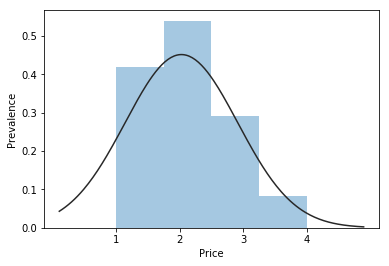

In [18]:
from scipy.stats import norm
#show how to make a dist plot for rices for a given city. but only one city
x = total_df[total_df['City'] == 'DC']['Price']
fig = sns.distplot(x, fit=norm, bins=4, kde = False)
plt.xticks(range(1,5))
plt.ylabel('Prevalence')
print(x.value_counts())
fig

See the total distributions all plotted on one chart

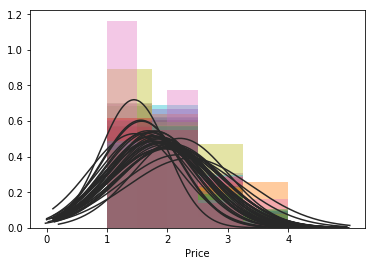

In [19]:
# overall, we see that there is a generall tendency for there to be mostly $ or $$ places and few $$$$
# This is actually a surprisintly large amount of variation
from scipy.stats import norm
for city in city_list:
    x = total_df[total_df['City'] == city]['Price']
    fig = sns.distplot(x, fit=norm, bins=4, kde = False)
    plt.xticks(range(5))
    fig

Compare each city's distribution side by side

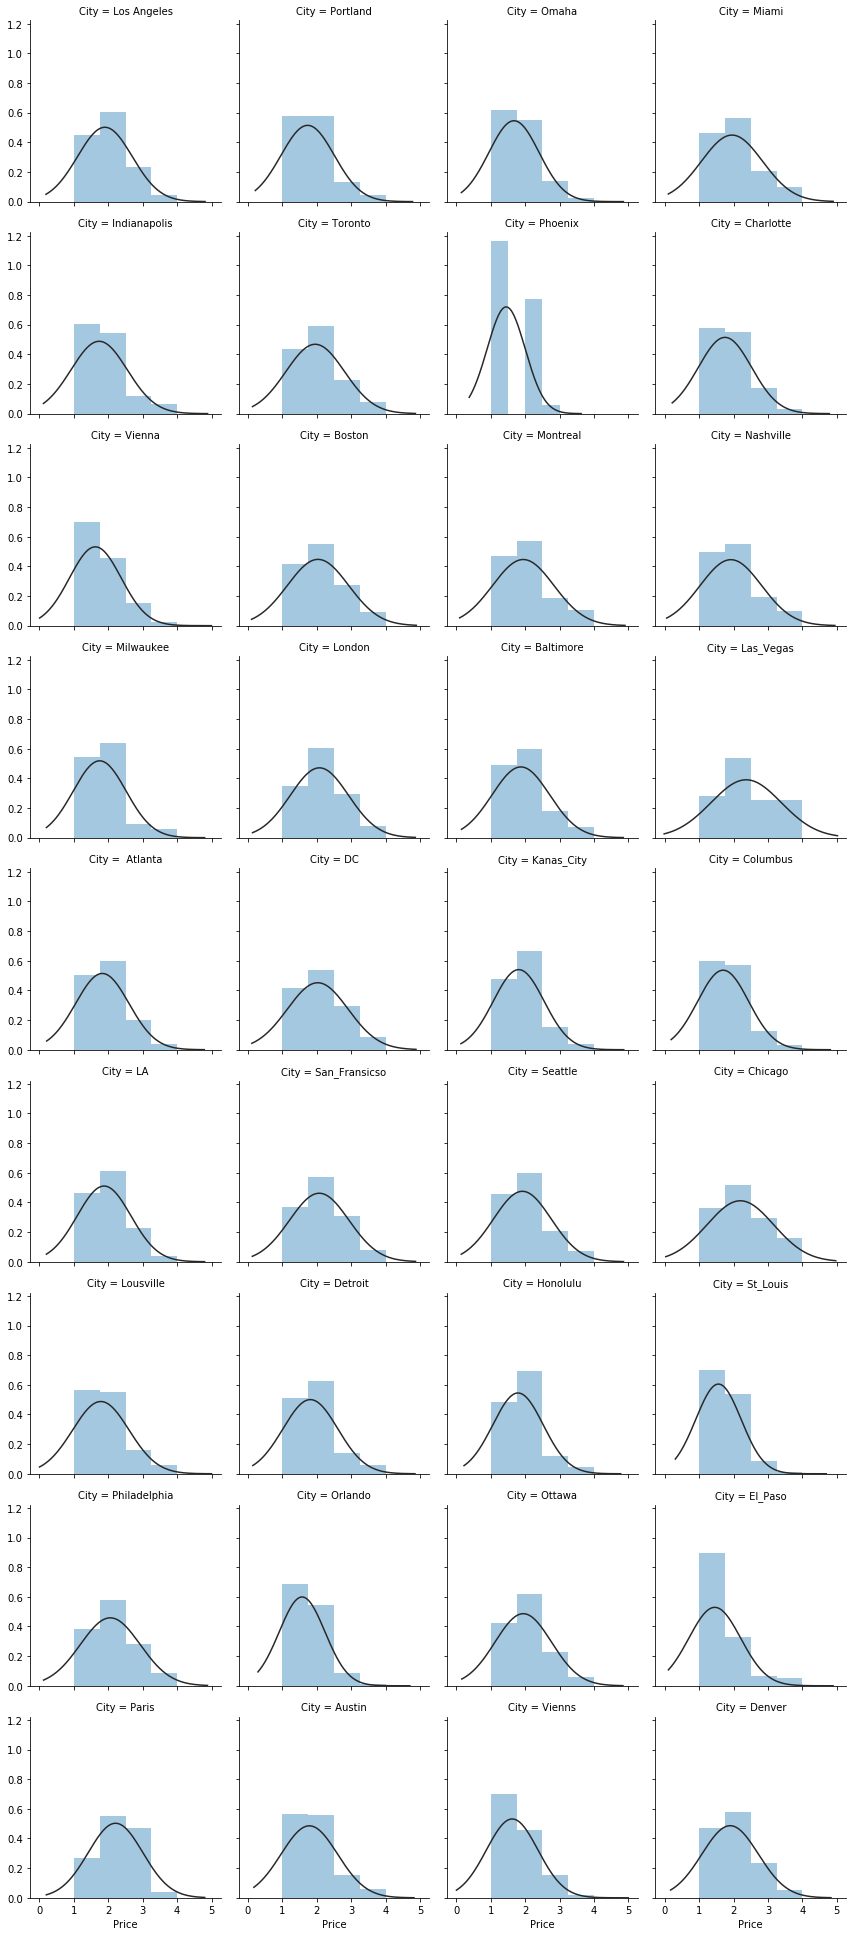

In [20]:
g = sns.FacetGrid(total_df, col="City", col_wrap=4)
g = g.map(sns.distplot, "Price", bins=4, fit=norm, kde=False)

## Compare distributions using a heatmap  
Further condense the visualization to see relative distributions all in one place  
Sample conclusions: We can see that the 1-2 price range is the most common. Price range 4 is actually suprisingly rare. Each city seems to follow a similar pattern of many 1s, more 2s, fewer 3s, and very few 4s.   

Looking at each city, we can see that places like El Paso, St. Louis, Orlando, and Vienna have a significant number of 1s. El Paso has an unusual lack of midrange restaurants (2s), and Las Vegas and Chicago both contain a large number of expensive venues (4s)

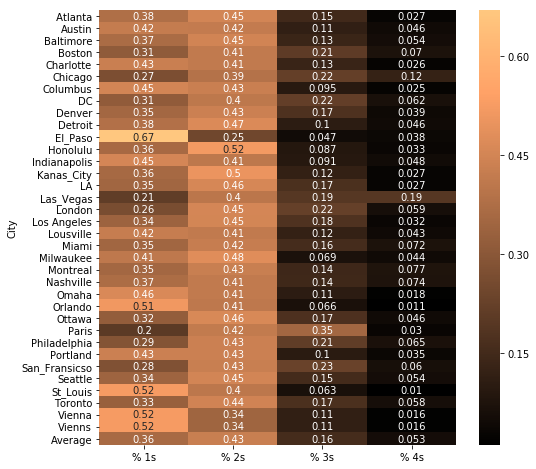

In [21]:
plt.figure(figsize=(8, 8))
sns.heatmap(city_df[['% 1s', '% 2s', '% 3s', '% 4s']], cmap='copper', annot=True)
#gist_heat#Purples#copper#bone

## Make a global food type stats df  
Approximitely how many instances of each exist in the world? What is their average price range? Where are they the most and least expensive? 

In [22]:
num_global = total_df['Venue Category'].value_counts()
num_global

American Restaurant                439
Pizza Place                        411
Italian Restaurant                 392
Café                               377
Mexican Restaurant                 336
Sandwich Place                     315
Restaurant                         248
Bakery                             246
French Restaurant                  232
Seafood Restaurant                 217
New American Restaurant            205
Steakhouse                         201
Burger Joint                       196
Sushi Restaurant                   193
Japanese Restaurant                174
Breakfast Spot                     146
Food Truck                         127
Deli / Bodega                      125
Thai Restaurant                    113
Vegetarian / Vegan Restaurant      110
Chinese Restaurant                 109
Diner                              107
Gastropub                          106
Fast Food Restaurant               104
Vietnamese Restaurant              103
Taco Place               

In [23]:
type_df = pd.DataFrame(total_df['Venue Category'].unique())
type_df.set_index(0, inplace=True)
del type_df.index.name
type_df

Empty DataFrame
Columns: []
Index: [Falafel Restaurant, Breakfast Spot, Mexican Restaurant, Donut Shop, Soup Place, Restaurant, Bakery, Salad Place, Taco Place, Café, Pizza Place, Japanese Restaurant, Fast Food Restaurant, Sushi Restaurant, Yoshoku Restaurant, Burger Joint, Southern / Soul Food Restaurant, Sandwich Place, Fried Chicken Joint, Deli / Bodega, Chinese Restaurant, Burrito Place, Vietnamese Restaurant, Food Truck, Thai Restaurant, Diner, Bagel Shop, Moroccan Restaurant, Indian Restaurant, Ramen Restaurant, Vegetarian / Vegan Restaurant, Brazilian Restaurant, Middle Eastern Restaurant, Gastropub, Seafood Restaurant, American Restaurant, Italian Restaurant, Cajun / Creole Restaurant, Greek Restaurant, Buffet, Argentinian Restaurant, Spanish Restaurant, Asian Restaurant, Latin American Restaurant, South American Restaurant, Mediterranean Restaurant, Peruvian Restaurant, African Restaurant, Indonesian Restaurant, Cuban Restaurant, French Restaurant, Eastern European Restaurant, Wings Joint, Steakhouse, German Restaurant, Gluten-free Restaurant, Caribbean Restaurant, Churrascaria, New American Restaurant, Hot Dog Joint, Snack Place, Tapas Restaurant, Irish Pub, BBQ Joint, Noodle House, Korean Restaurant, Persian Restaurant, Dumpling Restaurant, Mongolian Restaurant, Arepa Restaurant, Portuguese Restaurant, Poutine Place, Fondue Restaurant, Turkish Restaurant, Empanada Restaurant, Afghan Restaurant, Ethiopian Restaurant, Bavarian Restaurant, Dim Sum Restaurant, English Restaurant, Russian Restaurant, Modern European Restaurant, Cantonese Restaurant, Pakistani Restaurant, Belgian Restaurant, Filipino Restaurant, Comfort Food Restaurant, Hawaiian Restaurant, Trattoria/Osteria, Australian Restaurant, Tex-Mex Restaurant, Romanian Restaurant, Israeli Restaurant, Dutch Restaurant, Fish & Chips Shop, Szechuan Restaurant, Lebanese Restaurant, Bistro, Japanese Curry Restaurant, Udon Restaurant, ...]

In [24]:
type_df['Count'] =  total_df['Venue Category'].value_counts()
type_df.sort_values(by='Count',ascending=False, inplace=True)
# percentage of total global venues
print(type_df['Count'].sum())
type_df['% of global venues'] = type_df['Count'] / type_df['Count'].sum()
print(len(total_df))
type_df

6966
6966


Count  % of global venues
American Restaurant                439            0.063020
Pizza Place                        411            0.059001
Italian Restaurant                 392            0.056273
Café                               377            0.054120
Mexican Restaurant                 336            0.048234
Sandwich Place                     315            0.045220
Restaurant                         248            0.035601
Bakery                             246            0.035314
French Restaurant                  232            0.033305
Seafood Restaurant                 217            0.031151
New American Restaurant            205            0.029429
Steakhouse                         201            0.028854
Burger Joint                       196            0.028137
Sushi Restaurant                   193            0.027706
Japanese Restaurant                174            0.024978
Breakfast Spot                     146            0.020959
Food Truck                         127            0.018231
Deli / Bodega                      125            0.017944
Thai Restaurant                    113            0.016222
Vegetarian / Vegan Restaurant      110            0.015791
Chinese Restaurant                 109            0.015647
Diner                              107            0.015360
Gastropub                          106            0.015217
Fast Food Restaurant               104            0.014930
Vietnamese Restaurant              103            0.014786
Taco Place                         102            0.014643
BBQ Joint                           99            0.014212
Asian Restaurant                    97            0.013925
Mediterranean Restaurant            94            0.013494
Indian Restaurant                   73            0.010479
Southern / Soul Food Restaurant     65            0.009331
Donut Shop                          63            0.009044
Middle Eastern Restaurant           62            0.008900
Korean Restaurant                   60            0.008613
Salad Place                         56            0.008039
Greek Restaurant                    55            0.007895
Tapas Restaurant                    55            0.007895
Latin American Restaurant           50            0.007178
Fried Chicken Joint                 49            0.007034
Noodle House                        35            0.005024
Hot Dog Joint                       33            0.004737
Bagel Shop                          33            0.004737
Cuban Restaurant                    31            0.004450
Spanish Restaurant                  27            0.003876
Cajun / Creole Restaurant           25            0.003589
Brazilian Restaurant                24            0.003445
Ramen Restaurant                    24            0.003445
German Restaurant                   24            0.003445
Burrito Place                       22            0.003158
Caribbean Restaurant                22            0.003158
Peruvian Restaurant                 20            0.002871
Wings Joint                         20            0.002871
Portuguese Restaurant               17            0.002440
Falafel Restaurant                  17            0.002440
Ethiopian Restaurant                15            0.002153
Soup Place                          15            0.002153
Argentinian Restaurant              14            0.002010
Snack Place                         13            0.001866
Irish Pub                           13            0.001866
Filipino Restaurant                 11            0.001579
Bistro                               8            0.001148
South American Restaurant            8            0.001148
Moroccan Restaurant                  8            0.001148
Modern European Restaurant           8            0.001148
Arepa Restaurant                     7            0.001005
Dim Sum Restaurant                   7            0.001005
Turkish Restaurant                   6            0.000861
Creperie             

## Visualizing the frequency of each venue type
There are a large number of unique venue types. However, some are much more prevalant than others!
For fun, we can try using pi charts and waffle charts  
The pi chart comes out a mess due to the sheer number of venue types. However, you can still see interesting information. For example:
- American restaurants are actually more common than cafes
- There exist more gastropubs than Indian Restaurants  

~* Note: I am aware these visualizations are ugly. That is sort of the point*~

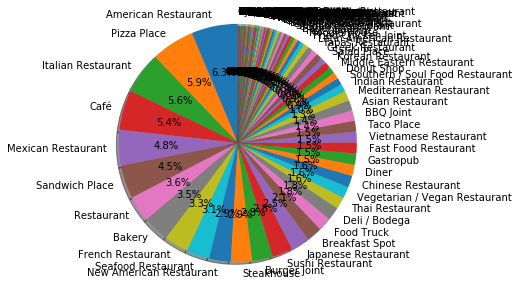

In [25]:
type_df_r = type_df.reset_index()
fig1, ax1 = plt.subplots()
ax1.pie(type_df_r['Count'], labels=list(type_df_r['index']), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.tight_layout()
plt.show()

Also for fun, we can try visualizing with waffle charts. This returns similar info with a more readable graphic. However, again there are so many venue types. Note that the legend goes in descending order of frequency 

There are  119 unique venue types


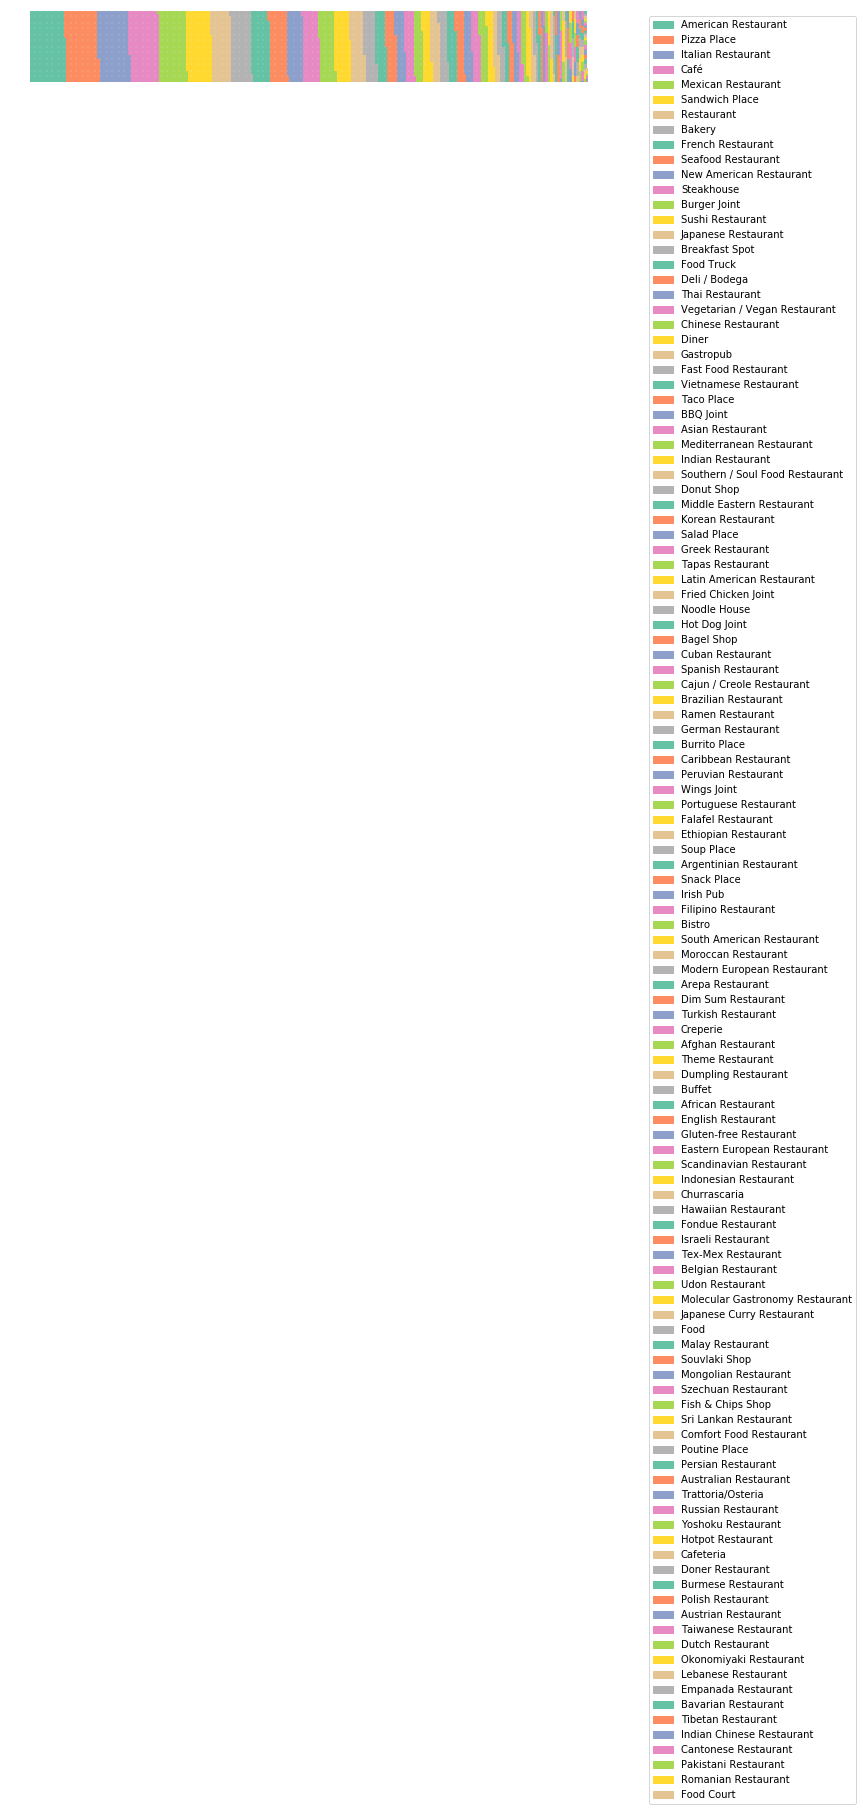

In [26]:
print('There are ', len(type_df_r), 'unique venue types')
fig = plt.figure(
    FigureClass=Waffle, 
    rows=30,
    values=type_df_r['Count'],
    labels=list(type_df_r['index']),
    figsize=(10, 5),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)}
)

A good point of expansion for this project is to aggregate similar restaurants. For example, Okonomiyaki Restaurants, Yoshoku Restaurants, and Sushi restaurants should likely be categorized under Japanese food. 
You may also want to remove some categories. For example "food" or "restaurant" is too general. There is also overlap -- technically chinese food is asian food, japanese is asian food, and so is vietnamese, thai, etc. It could make sense to remove the category "asian restaurants", or to combine each asian food venue under "asian". The same can be said for all africal venues and middle eastern venues

## Use a venue type dataframe to hold counts and information on prevalance and pricing

In [27]:
#Average price range globaly
type_prices = total_df.groupby('Venue Category').mean()
type_df['avg price'] = type_prices['Price']
type_prices

City Latitude  City Longitude  \
Venue Category                                                   
Afghan Restaurant                    40.132991      -76.392297   
African Restaurant                   37.502655      -85.447239   
American Restaurant                  37.944762      -91.956472   
Arepa Restaurant                     41.455811      -66.911433   
Argentinian Restaurant               37.303137      -65.785865   
Asian Restaurant                     38.058533      -88.121524   
Australian Restaurant                34.805780      -99.429004   
Austrian Restaurant                  51.515839       -0.123997   
BBQ Joint                            37.438715      -91.843548   
Bagel Shop                           36.603847      -94.243073   
Bakery                               39.270122      -86.000738   
Bavarian Restaurant                  36.117758     -115.169727   
Belgian Restaurant                   39.862133      -75.438884   
Bistro                               41.221954      -68.120146   
Brazilian Restaurant                 38.713039      -91.793289   
Breakfast Spot                       40.284461      -89.576394   
Buffet                               36.974160     -111.964747   
Burger Joint                         38.874243      -86.622925   
Burmese Restaurant                   37.776198     -122.417002   
Burrito Place                        36.672383      -97.743805   
Cafeteria                            42.336955      -83.052963   
Café                                 39.596517      -87.202959   
Cajun / Creole Restaurant            36.089084     -103.957483   
Cantonese Restaurant                 51.515839       -0.123997   
Caribbean Restaurant                 38.819478      -88.130623   
Chinese Restaurant                   37.068224      -96.914240   
Churrascaria                         37.808591      -88.130542   
Comfort Food Restaurant              41.805862      -81.191550   
Creperie                             41.818640      -74.340232   
Cuban Restaurant                     32.976325      -84.566687   
Deli / Bodega                        39.611247      -84.211338   
Dim Sum Restaurant                   41.170082      -66.801004   
Diner                                37.611209      -96.550039   
Doner Restaurant                     43.651534      -79.385576   
Donut Shop                           40.338863      -96.001878   
Dumpling Restaurant                  43.362166     -100.168293   
Dutch Restaurant                     39.951027      -75.164180   
Eastern European Restaurant          38.723302      -64.224585   
Empanada Restaurant                  51.515839       -0.123997   
English Restaurant                   49.202877      -15.132034   
Ethiopian Restaurant                 39.833289      -85.235953   
Falafel Restaurant                   41.070755      -66.370385   
Fast Food Restaurant                 36.207634      -91.551359   
Filipino Restaurant                  36.192751     -112.773996   
Fish & Chips Shop                    47.188323      -35.613390   
Fondue Restaurant                    37.671066      -93.671916   
Food                                 33.221140     -117.688603   
Food Court                           21.308780     -157.860352   
Food Truck                           38.142545      -96.533310   
French Restaurant                    42.652025      -59.574326   
Fried Chicken Joint                  36.073457      -95.883255   
Gastropub                            40.161790      -86.057855   
German Restaurant                    40.268536      -96.666760   
Gluten-free Restaurant               34.132139      -85.677533   
Greek Restaurant                     40.234885      -78.866197   
Hawaiian Restaurant                  32.002935     -140.120135   
Hot Dog Joint                        37.969656      -94.786918   
Hotpot Restaurant                    21.308780     -157.860352   
Indian Chinese Restaurant            33.775697      -84.384971   
Indian 

In [28]:
type_df

Count  % of global venues  avg price
American Restaurant                439            0.063020   2.298405
Pizza Place                        411            0.059001   1.343066
Italian Restaurant                 392            0.056273   2.451531
Café                               377            0.054120   1.244032
Mexican Restaurant                 336            0.048234   1.419643
Sandwich Place                     315            0.045220   1.174603
Restaurant                         248            0.035601   2.201613
Bakery                             246            0.035314   1.162602
French Restaurant                  232            0.033305   2.982759
Seafood Restaurant                 217            0.031151   2.861751
New American Restaurant            205            0.029429   2.912195
Steakhouse                         201            0.028854   3.328358
Burger Joint                       196            0.028137   1.418367
Sushi Restaurant                   193            0.027706   2.238342
Japanese Restaurant                174            0.024978   2.333333
Breakfast Spot                     146            0.020959   1.465753
Food Truck                         127            0.018231   1.078740
Deli / Bodega                      125            0.017944   1.360000
Thai Restaurant                    113            0.016222   1.964602
Vegetarian / Vegan Restaurant      110            0.015791   1.918182
Chinese Restaurant                 109            0.015647   1.577982
Diner                              107            0.015360   1.429907
Gastropub                          106            0.015217   2.462264
Fast Food Restaurant               104            0.014930   1.028846
Vietnamese Restaurant              103            0.014786   1.737864
Taco Place                         102            0.014643   1.215686
BBQ Joint                           99            0.014212   1.878788
Asian Restaurant                    97            0.013925   2.195876
Mediterranean Restaurant            94            0.013494   2.138298
Indian Restaurant                   73            0.010479   2.054795
Southern / Soul Food Restaurant     65            0.009331   1.661538
Donut Shop                          63            0.009044   1.095238
Middle Eastern Restaurant           62            0.008900   1.790323
Korean Restaurant                   60            0.008613   2.000000
Salad Place                         56            0.008039   1.232143
Greek Restaurant                    55            0.007895   2.000000
Tapas Restaurant                    55            0.007895   2.781818
Latin American Restaurant           50            0.007178   1.980000
Fried Chicken Joint                 49            0.007034   1.244898
Noodle House                        35            0.005024   1.428571
Hot Dog Joint                       33            0.004737   1.090909
Bagel Shop                          33            0.004737   1.030303
Cuban Restaurant                    31            0.004450   1.774194
Spanish Restaurant                  27            0.003876   2.222222
Cajun / Creole Restaurant           25            0.003589   2.040000
Brazilian Restaurant                24            0.003445   2.500000
Ramen Restaurant                    24            0.003445   1.916667
German Restaurant                   24            0.003445   2.208333
Burrito Place                       22            0.003158   1.136364
Caribbean Restaurant                22            0.003158   1.863636
Peruvian Restaurant                 20            0.002871   2.250000
Wings Joint                         20            0.002871   1.500000
Portuguese Restaurant               17            0.002440   2.235294
Falafel Restaurant                  17            0.002440   1.176471
Ethiopian Restaurant                15            0.002153   1.933333
Soup Place                          15            0.002153   1.066667
Argentinian Restaurant              14     

## Generate a diversity score to compare each city
Cannot just look at unique count. For example, LA may have 300 types of restaurants but only 100 restaurants. Austin may also have 100 types but 500 restaurants, so less diverse.
Ratio of the number of unique to the total number

In [29]:
unique_counts = total_df.groupby('City')['Venue Category'].nunique()
city_df['# Unique Catagories'] = unique_counts
city_df

Price 1     Price 2    Price 3    Price 4  Total # Venues  \
City                                                                       
 Atlanta          84.0  100.000000  33.000000   6.000000           223.0   
Austin           100.0   99.000000  27.000000  11.000000           237.0   
Baltimore         82.0  100.000000  30.000000  12.000000           224.0   
Boston            75.0  100.000000  50.000000  17.000000           242.0   
Charlotte        100.0   96.000000  30.000000   6.000000           232.0   
Chicago           66.0   95.000000  54.000000  30.000000           245.0   
Columbus          71.0   68.000000  15.000000   4.000000           158.0   
DC                76.0   98.000000  53.000000  15.000000           242.0   
Denver            81.0  100.000000  40.000000   9.000000           230.0   
Detroit           66.0   81.000000  18.000000   8.000000           173.0   
El_Paso           71.0   26.000000   5.000000   4.000000           106.0   
Honolulu          66.0   95.000000  16.000000   6.000000           183.0   
Indianapolis      75.0   67.000000  15.000000   8.000000           165.0   
Kanas_City        40.0   56.000000  13.000000   3.000000           112.0   
LA                76.0  100.000000  37.000000   6.000000           219.0   
Las_Vegas         53.0  100.000000  48.000000  48.000000           249.0   
London            58.0  100.000000  49.000000  13.000000           220.0   
Los Angeles       75.0  100.000000  39.000000   7.000000           221.0   
Lousville         39.0   38.000000  11.000000   4.000000            92.0   
Miami             82.0  100.000000  37.000000  17.000000           236.0   
Milwaukee         83.0   97.000000  14.000000   9.000000           203.0   
Montreal          82.0  100.000000  33.000000  18.000000           233.0   
Nashville         70.0   78.000000  27.000000  14.000000           189.0   
Omaha             53.0   47.000000  12.000000   2.000000           114.0   
Orlando           93.0   74.000000  12.000000   2.000000           181.0   
Ottawa            69.0  100.000000  37.000000  10.000000           216.0   
Paris             47.0   97.000000  82.000000   7.000000           233.0   
Philadelphia      66.0  100.000000  49.000000  15.000000           230.0   
Portland         100.0  100.000000  23.000000   8.000000           231.0   
San_Fransicso     65.0  100.000000  54.000000  14.000000           233.0   
Seattle           76.0  100.000000  34.000000  12.000000           222.0   
St_Louis         100.0   77.000000  12.000000   2.000000           191.0   
Toronto           74.0  100.000000  38.000000  13.000000           225.0   
Vienna            32.0   21.000000   7.000000   1.000000            61.0   
Vienns            32.0   21.000000   7.000000   1.000000            61.0   
Average           70.8   83.742857  30.314286  10.342857           195.2   

                   % 1s      % 2s      % 3s      % 4s  # Unique Catagories  
City                                                                        
 Atlanta       0.376682  0.448430  0.147982  0.026906                 57.0  
Austin         0.421941  0.417722  0.113924  0.046414                 54.0  
Baltimore      0.366071  0.446429  0.133929  0.053571                 56.0  
Boston         0.309917  0.413223  0.206612  0.070248                 44.0  
Charlotte      0.431034  0.413793  0.129310  0.025862                 48.0  
Chicago        0.269388  0.387755  0.220408  0.122449                 46.0  
Columbus       0.449367  0.430380  0.094937  0.025316                 43.0  
DC             0.314050  0.404959  0.219008  0.061983                 58.0  
Denver         0.352174  0.434783  0.173913  0.039130                 50.0  
Detroit        0.381503  0.468208  0.104046  0.046243                 43.0  
El_Paso        0.669811  0.245283  0.047170  0.037736                 31.0  
Honolulu       0.360656  0.519126  0.087432  0.032787                 43.0  
Indianapolis   0.454545  0.406061  0.090909  0.0

In [30]:
unique_counts #making sure that dataframe above keeps proper order

City
 Atlanta         57
Austin           54
Baltimore        56
Boston           44
Charlotte        48
Chicago          46
Columbus         43
DC               58
Denver           50
Detroit          43
El_Paso          31
Honolulu         43
Indianapolis     41
Kanas_City       39
LA               51
Las_Vegas        49
London           57
Los Angeles      50
Lousville        33
Miami            48
Milwaukee        51
Montreal         49
Nashville        45
Omaha            33
Orlando          41
Ottawa           50
Paris            47
Philadelphia     56
Phoenix          41
Portland         53
San_Fransicso    59
Seattle          47
St_Louis         46
Toronto          49
Vienna           31
Vienns           31
Name: Venue Category, dtype: int64

Make new feature: Diversity Score. The number of unique categories / number of total venues

Potential Concern: Could make the smaller cities look REALLY good.  Because there are only SO MANY types that exis, so need to be wary of small cities. 
Ex. Vienna only has 61 venues and 31 are unique
However, we don't mind in this case. The few category types still means that there is more opportunity for variety


In [31]:
city_df['Diversity_Score'] = city_df['# Unique Catagories'] / city_df['Total # Venues']

city_df.at['Average', '# Unique Catagories'] = city_df['# Unique Catagories'].mean()
city_df.at['Average', 'Diversity_Score'] = city_df['Diversity_Score'].mean()
# city_df

In [32]:
city_df['Avg Price'] = (city_df['Price 1'] + 2*city_df['Price 2'] + 3*city_df['Price 3'] + 4*city_df['Price 4'])/ city_df['Total # Venues']
city_df

Price 1     Price 2    Price 3    Price 4  Total # Venues  \
City                                                                       
 Atlanta          84.0  100.000000  33.000000   6.000000           223.0   
Austin           100.0   99.000000  27.000000  11.000000           237.0   
Baltimore         82.0  100.000000  30.000000  12.000000           224.0   
Boston            75.0  100.000000  50.000000  17.000000           242.0   
Charlotte        100.0   96.000000  30.000000   6.000000           232.0   
Chicago           66.0   95.000000  54.000000  30.000000           245.0   
Columbus          71.0   68.000000  15.000000   4.000000           158.0   
DC                76.0   98.000000  53.000000  15.000000           242.0   
Denver            81.0  100.000000  40.000000   9.000000           230.0   
Detroit           66.0   81.000000  18.000000   8.000000           173.0   
El_Paso           71.0   26.000000   5.000000   4.000000           106.0   
Honolulu          66.0   95.000000  16.000000   6.000000           183.0   
Indianapolis      75.0   67.000000  15.000000   8.000000           165.0   
Kanas_City        40.0   56.000000  13.000000   3.000000           112.0   
LA                76.0  100.000000  37.000000   6.000000           219.0   
Las_Vegas         53.0  100.000000  48.000000  48.000000           249.0   
London            58.0  100.000000  49.000000  13.000000           220.0   
Los Angeles       75.0  100.000000  39.000000   7.000000           221.0   
Lousville         39.0   38.000000  11.000000   4.000000            92.0   
Miami             82.0  100.000000  37.000000  17.000000           236.0   
Milwaukee         83.0   97.000000  14.000000   9.000000           203.0   
Montreal          82.0  100.000000  33.000000  18.000000           233.0   
Nashville         70.0   78.000000  27.000000  14.000000           189.0   
Omaha             53.0   47.000000  12.000000   2.000000           114.0   
Orlando           93.0   74.000000  12.000000   2.000000           181.0   
Ottawa            69.0  100.000000  37.000000  10.000000           216.0   
Paris             47.0   97.000000  82.000000   7.000000           233.0   
Philadelphia      66.0  100.000000  49.000000  15.000000           230.0   
Portland         100.0  100.000000  23.000000   8.000000           231.0   
San_Fransicso     65.0  100.000000  54.000000  14.000000           233.0   
Seattle           76.0  100.000000  34.000000  12.000000           222.0   
St_Louis         100.0   77.000000  12.000000   2.000000           191.0   
Toronto           74.0  100.000000  38.000000  13.000000           225.0   
Vienna            32.0   21.000000   7.000000   1.000000            61.0   
Vienns            32.0   21.000000   7.000000   1.000000            61.0   
Average           70.8   83.742857  30.314286  10.342857           195.2   

                   % 1s      % 2s      % 3s      % 4s  # Unique Catagories  \
City                                                                         
 Atlanta       0.376682  0.448430  0.147982  0.026906            57.000000   
Austin         0.421941  0.417722  0.113924  0.046414            54.000000   
Baltimore      0.366071  0.446429  0.133929  0.053571            56.000000   
Boston         0.309917  0.413223  0.206612  0.070248            44.000000   
Charlotte      0.431034  0.413793  0.129310  0.025862            48.000000   
Chicago        0.269388  0.387755  0.220408  0.122449            46.000000   
Columbus       0.449367  0.430380  0.094937  0.025316            43.000000   
DC             0.314050  0.404959  0.219008  0.061983            58.000000   
Denver         0.352174  0.434783  0.173913  0.039130            50.000000   
Detroit        0.381503  0.468208  0.104046  0.046243            43.000000   
El_Paso        0.669811  0.245283  0.047170  0.037736            31.000000   
Honolulu       0.360656  0.519126  0.087432  0.032787            43.000000   
Indianapolis   0.454545  0.406061 

In [33]:
a = city_df.sort_values('Avg Price', ascending=False)[['Avg Price']]
a = a.reset_index().rename(columns={a.index.name:'avg_price_l2h_City'}) #low to high
a.head(3)

avg_price_l2h_City  Avg Price
0          Las_Vegas   2.365462
1              Paris   2.210300
2            Chicago   2.195918

In [34]:
b = city_df.sort_values('Diversity_Score', ascending=False)[['Diversity_Score']]
b = b.reset_index().rename(columns={b.index.name:'div_score_l2h_City'}) #low to high
b.head(3)

div_score_l2h_City  Diversity_Score
0             Vienns         0.508197
1             Vienna         0.508197
2          Lousville         0.358696

In [35]:
ranking_df = a['avg_price_l2h_City'].to_frame().join(b['div_score_l2h_City'])
ranking_df

avg_price_l2h_City div_score_l2h_City
0           Las_Vegas             Vienns
1               Paris             Vienna
2             Chicago          Lousville
3              London         Kanas_City
4       San_Fransicso            El_Paso
5        Philadelphia              Omaha
6              Boston           Columbus
7                  DC             London
8             Toronto            Average
9               Miami            Atlanta
10             Ottawa      San_Fransicso
11           Montreal          Milwaukee
12          Nashville          Baltimore
13            Seattle            Detroit
14        Los Angeles       Indianapolis
15             Denver       Philadelphia
16            Average           St_Louis
17                 LA                 DC
18          Baltimore          Nashville
19            Atlanta           Honolulu
20            Detroit                 LA
21         Kanas_City             Ottawa
22           Honolulu           Portland
23             Austin             Austin
24          Lousville            Orlando
25          Charlotte        Los Angeles
26          Milwaukee            Toronto
27           Portland             Denver
28       Indianapolis            Seattle
29           Columbus           Montreal
30              Omaha          Charlotte
31             Vienna              Miami
32             Vienns              Paris
33            Orlando          Las_Vegas
34           St_Louis            Chicago
35            El_Paso             Boston

## Normalize features, generate an aggregate recommendation score, and determine the "best" location
Weight the diversity score and the average price. The user inputs the importance of each feature by changing the weight.
Normalize these features first (between 0 and 1) so the comparison is fair (use the minmax scalar if data is not normally distributed)  


In [36]:
city_summary_df = city_df[['Diversity_Score', 'Avg Price']]

x = city_summary_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_features = pd.DataFrame(x_scaled)

city_summary_df = pd.merge(city_summary_df.reset_index(), normalized_features, left_index=True, right_index=True)
city_summary_df.set_index('City', inplace=True)
city_summary_df = city_summary_df.rename(columns={0:'Div_score_normalized', 1:'Avg_price_normalized'})
city_summary_df


Diversity_Score  Avg Price  Div_score_normalized  \
City                                                              
 Atlanta              0.255605   1.825112              0.226079   
Austin                0.227848   1.784810              0.141032   
Baltimore             0.250000   1.875000              0.208904   
Boston                0.181818   2.037190              0.000000   
Charlotte             0.206897   1.750000              0.076838   
Chicago               0.187755   2.195918              0.018190   
Columbus              0.272152   1.696203              0.276776   
DC                    0.239669   2.028926              0.177252   
Denver                0.217391   1.900000              0.108993   
Detroit               0.248555   1.815029              0.204476   
El_Paso               0.292453   1.452830              0.338976   
Honolulu              0.234973   1.792350              0.162861   
Indianapolis          0.248485   1.733333              0.204262   
Kanas_City            0.348214   1.812500              0.509826   
LA                    0.232877   1.876712              0.156440   
Las_Vegas             0.196787   2.365462              0.045864   
London                0.259091   2.077273              0.236758   
Los Angeles           0.226244   1.900452              0.136119   
Lousville             0.358696   1.782609              0.541940   
Miami                 0.203390   1.953390              0.066094   
Milwaukee             0.251232   1.748768              0.212677   
Montreal              0.210300   1.944206              0.087268   
Nashville             0.238095   1.920635              0.172429   
Omaha                 0.289474   1.675439              0.329849   
Orlando               0.226519   1.574586              0.136961   
Ottawa                0.231481   1.944444              0.152165   
Paris                 0.201717   2.210300              0.060968   
Philadelphia          0.243478   2.056522              0.188922   
Portland              0.229437   1.735931              0.145901   
San_Fransicso         0.253219   2.072961              0.218767   
Seattle               0.211712   1.918919              0.091592   
St_Louis              0.240838   1.560209              0.180831   
Toronto               0.217778   1.955556              0.110178   
Vienna                0.508197   1.622951              1.000000   
Vienns                0.508197   1.622951              1.000000   
Average               0.255731   1.898566              0.226462   

               Avg_price_normalized  
City                                 
 Atlanta                   0.407921  
Austin                     0.363761  
Baltimore                  0.462585  
Boston                     0.640302  
Charlotte                  0.325619  
Chicago                    0.814226  
Columbus                   0.266671  
DC                         0.631246  
Denver                     0.489978  
Detroit                    0.396873  
El_Paso                    0.000000  
Honolulu                   0.372023  
Indianapolis               0.307356  
Kanas_City                 0.394102  
LA                         0.464461  
Las_Vegas                  1.000000  
London                     0.684222  
Los Angeles                0.490474  
Lousville                  0.361349  
Miami                      0.548479  
Milwaukee                  0.324269  
Montreal                   0.538416  
Nashville                  0.512589  
Omaha                      0.243919  
Orlando                    0.133411  
Ottawa                     0.538678  
Paris                      0.829985  
Philadelphia               0.661484  
Portland                   0.310202  
San_Fransicso              0.679498  
Seattle                    0.510708  
St_Louis                   0.117659  
Toronto                    0.550852  
Vienna                     0.186407  
Vienns                     0.186407  
Average                    0.488407

However, performing a weighted sum using this div_score weighted means that diverse cities are FAVORED  
We want to flip this. A region with fewer unique venues per venue should be rated with a higher value.   
So the lowest diversity should be 1.000 not 0.00000  
So use a 1-div_score. Thus a score of .003% gets a GOOD score of .997.   

In [37]:
city_summary_df['Div_score_normalized'] = 1 - city_summary_df['Div_score_normalized'] 
city_summary_df

Diversity_Score  Avg Price  Div_score_normalized  \
City                                                              
 Atlanta              0.255605   1.825112              0.773921   
Austin                0.227848   1.784810              0.858968   
Baltimore             0.250000   1.875000              0.791096   
Boston                0.181818   2.037190              1.000000   
Charlotte             0.206897   1.750000              0.923162   
Chicago               0.187755   2.195918              0.981810   
Columbus              0.272152   1.696203              0.723224   
DC                    0.239669   2.028926              0.822748   
Denver                0.217391   1.900000              0.891007   
Detroit               0.248555   1.815029              0.795524   
El_Paso               0.292453   1.452830              0.661024   
Honolulu              0.234973   1.792350              0.837139   
Indianapolis          0.248485   1.733333              0.795738   
Kanas_City            0.348214   1.812500              0.490174   
LA                    0.232877   1.876712              0.843560   
Las_Vegas             0.196787   2.365462              0.954136   
London                0.259091   2.077273              0.763242   
Los Angeles           0.226244   1.900452              0.863881   
Lousville             0.358696   1.782609              0.458060   
Miami                 0.203390   1.953390              0.933906   
Milwaukee             0.251232   1.748768              0.787323   
Montreal              0.210300   1.944206              0.912732   
Nashville             0.238095   1.920635              0.827571   
Omaha                 0.289474   1.675439              0.670151   
Orlando               0.226519   1.574586              0.863039   
Ottawa                0.231481   1.944444              0.847835   
Paris                 0.201717   2.210300              0.939032   
Philadelphia          0.243478   2.056522              0.811078   
Portland              0.229437   1.735931              0.854099   
San_Fransicso         0.253219   2.072961              0.781233   
Seattle               0.211712   1.918919              0.908408   
St_Louis              0.240838   1.560209              0.819169   
Toronto               0.217778   1.955556              0.889822   
Vienna                0.508197   1.622951              0.000000   
Vienns                0.508197   1.622951              0.000000   
Average               0.255731   1.898566              0.773538   

               Avg_price_normalized  
City                                 
 Atlanta                   0.407921  
Austin                     0.363761  
Baltimore                  0.462585  
Boston                     0.640302  
Charlotte                  0.325619  
Chicago                    0.814226  
Columbus                   0.266671  
DC                         0.631246  
Denver                     0.489978  
Detroit                    0.396873  
El_Paso                    0.000000  
Honolulu                   0.372023  
Indianapolis               0.307356  
Kanas_City                 0.394102  
LA                         0.464461  
Las_Vegas                  1.000000  
London                     0.684222  
Los Angeles                0.490474  
Lousville                  0.361349  
Miami                      0.548479  
Milwaukee                  0.324269  
Montreal                   0.538416  
Nashville                  0.512589  
Omaha                      0.243919  
Orlando                    0.133411  
Ottawa                     0.538678  
Paris                      0.829985  
Philadelphia               0.661484  
Portland                   0.310202  
San_Fransicso              0.679498  
Seattle                    0.510708  
St_Louis                   0.117659  
Toronto                    0.550852  
Vienna                     0.186407  
Vienns                     0.186407  
Average                    0.488407

Make the final feature -- overall tradeoff score using user-specified parameters

In [38]:
diversity_weight = .3
price_weight = .7

city_summary_df['Tradeoff score'] = diversity_weight*city_summary_df['Div_score_normalized'] + price_weight*city_summary_df['Avg_price_normalized']
city_summary_df.sort_values('Tradeoff score', ascending=False)

Diversity_Score  Avg Price  Div_score_normalized  \
City                                                              
Las_Vegas             0.196787   2.365462              0.954136   
Chicago               0.187755   2.195918              0.981810   
Paris                 0.201717   2.210300              0.939032   
Boston                0.181818   2.037190              1.000000   
San_Fransicso         0.253219   2.072961              0.781233   
London                0.259091   2.077273              0.763242   
Philadelphia          0.243478   2.056522              0.811078   
DC                    0.239669   2.028926              0.822748   
Miami                 0.203390   1.953390              0.933906   
Toronto               0.217778   1.955556              0.889822   
Montreal              0.210300   1.944206              0.912732   
Ottawa                0.231481   1.944444              0.847835   
Seattle               0.211712   1.918919              0.908408   
Denver                0.217391   1.900000              0.891007   
Nashville             0.238095   1.920635              0.827571   
Los Angeles           0.226244   1.900452              0.863881   
LA                    0.232877   1.876712              0.843560   
Average               0.255731   1.898566              0.773538   
Baltimore             0.250000   1.875000              0.791096   
 Atlanta              0.255605   1.825112              0.773921   
Detroit               0.248555   1.815029              0.795524   
Austin                0.227848   1.784810              0.858968   
Honolulu              0.234973   1.792350              0.837139   
Charlotte             0.206897   1.750000              0.923162   
Portland              0.229437   1.735931              0.854099   
Milwaukee             0.251232   1.748768              0.787323   
Indianapolis          0.248485   1.733333              0.795738   
Kanas_City            0.348214   1.812500              0.490174   
Columbus              0.272152   1.696203              0.723224   
Lousville             0.358696   1.782609              0.458060   
Omaha                 0.289474   1.675439              0.670151   
Orlando               0.226519   1.574586              0.863039   
St_Louis              0.240838   1.560209              0.819169   
El_Paso               0.292453   1.452830              0.661024   
Vienna                0.508197   1.622951              0.000000   
Vienns                0.508197   1.622951              0.000000   

               Avg_price_normalized  Tradeoff score  
City                                                 
Las_Vegas                  1.000000        0.986241  
Chicago                    0.814226        0.864501  
Paris                      0.829985        0.862699  
Boston                     0.640302        0.748211  
San_Fransicso              0.679498        0.710018  
London                     0.684222        0.707928  
Philadelphia               0.661484        0.706362  
DC                         0.631246        0.688697  
Miami                      0.548479        0.664107  
Toronto                    0.550852        0.652543  
Montreal                   0.538416        0.650711  
Ottawa                     0.538678        0.631425  
Seattle                    0.510708        0.630018  
Denver                     0.489978        0.610287  
Nashville                  0.512589        0.607083  
Los Angeles                0.490474        0.602496  
LA                         0.464461        0.578191  
Average                    0.488407        0.573946  
Baltimore                  0.462585        0.561138  
 Atlanta                   0.407921        0.517721  
Detroit                    0.396873        0.516468  
Austin                     0.363761        0.512323  
Honolulu                   0.372023        0.511557  
Charlotte                  0.325619        0.504882  
Portland                   0.310202        0.473371  
Milwaukee 

In [39]:
 ## now take the city with the maximum score. Return the type of restaurants that are the most and least common (5 of each)
city_summary_df_r = city_summary_df.reset_index().sort_values('Tradeoff score', ascending=False)
city_summary_df_r.reset_index(inplace=True)
desired_city = city_summary_df_r.loc[0]['City']


desired_city_df = total_df[total_df['City'] == desired_city]
venue_types = desired_city_df[['Venue Category']]
counts = venue_types['Venue Category'].value_counts()
type(counts)
#test: top 5 should return steakhouse, american rest, italian, pizza, burger
# least should return Bavarian to Diner
counts.index[0:5]

top_5_most_common =[counts.index[i] for i in range(5)]# counts.index[0:5]

# return all of the instances of venues with the lowest frequency. For example, a city may have 8 types with only one occurance
# another city may have no entirely unique ones, but may have 6 tyes with 2 instances. 
# make sure to return at least 4 choices
top_5_least_common = [counts.index[i] for i in range(len(counts) - 5, len(counts))]
top_5_least_common
print(desired_city)
city_summary_df_r

Las_Vegas


index           City  Diversity_Score  Avg Price  Div_score_normalized  \
0      15      Las_Vegas         0.196787   2.365462              0.954136   
1       5        Chicago         0.187755   2.195918              0.981810   
2      26          Paris         0.201717   2.210300              0.939032   
3       3         Boston         0.181818   2.037190              1.000000   
4      29  San_Fransicso         0.253219   2.072961              0.781233   
5      16         London         0.259091   2.077273              0.763242   
6      27   Philadelphia         0.243478   2.056522              0.811078   
7       7             DC         0.239669   2.028926              0.822748   
8      19          Miami         0.203390   1.953390              0.933906   
9      32        Toronto         0.217778   1.955556              0.889822   
10     21       Montreal         0.210300   1.944206              0.912732   
11     25         Ottawa         0.231481   1.944444              0.847835   
12     30        Seattle         0.211712   1.918919              0.908408   
13      8         Denver         0.217391   1.900000              0.891007   
14     22      Nashville         0.238095   1.920635              0.827571   
15     17    Los Angeles         0.226244   1.900452              0.863881   
16     14             LA         0.232877   1.876712              0.843560   
17     35        Average         0.255731   1.898566              0.773538   
18      2      Baltimore         0.250000   1.875000              0.791096   
19      0        Atlanta         0.255605   1.825112              0.773921   
20      9        Detroit         0.248555   1.815029              0.795524   
21      1         Austin         0.227848   1.784810              0.858968   
22     11       Honolulu         0.234973   1.792350              0.837139   
23      4      Charlotte         0.206897   1.750000              0.923162   
24     28       Portland         0.229437   1.735931              0.854099   
25     20      Milwaukee         0.251232   1.748768              0.787323   
26     12   Indianapolis         0.248485   1.733333              0.795738   
27     13     Kanas_City         0.348214   1.812500              0.490174   
28      6       Columbus         0.272152   1.696203              0.723224   
29     18      Lousville         0.358696   1.782609              0.458060   
30     23          Omaha         0.289474   1.675439              0.670151   
31     24        Orlando         0.226519   1.574586              0.863039   
32     31       St_Louis         0.240838   1.560209              0.819169   
33     10        El_Paso         0.292453   1.452830              0.661024   
34     33         Vienna         0.508197   1.622951              0.000000   
35     34         Vienns         0.508197   1.622951              0.000000   

    Avg_price_normalized  Tradeoff score  
0               1.000000        0.986241  
1               0.814226        0.864501  
2               0.829985        0.862699  
3               0.640302        0.748211  
4               0.679498        0.710018  
5               0.684222        0.707928  
6               0.661484        0.706362  
7               0.631246        0.688697  
8               0.548479        0.664107  
9               0.550852        0.652543  
10              0.538416        0.650711  
11              0.538678        0.631425  
12              0.510708        0.630018  
13              0.489978        0.610287  
14              0.512589        0.607083  
15              0.490474        0.602496  
16              0.464461        0.578191  
17              0.488407        0.573946  
18              0.462585        0.561138  
19              0.407921        0.517721  
20              0.396873        0.516468  
21              0.363761        0.512323  
22              0.372023        0.511557  
23              0.325619        0.504882  
24              0.310202        0.473371  

### Generate a report for the most optimal selection set

In [40]:
print("Avoid these types since they are the most common: ")
for venue in top_5_most_common:
    print('\n -' + venue)
print('Choose from these since they are the least common: ')
for venue in top_5_least_common:
    print('\n -' + venue)
    

Avoid these types since they are the most common: 

 -Steakhouse

 -American Restaurant

 -Italian Restaurant

 -Pizza Place

 -Burger Joint
Choose from these since they are the least common: 

 -Vegetarian / Vegan Restaurant

 -Brazilian Restaurant

 -Bagel Shop

 -Cajun / Creole Restaurant

 -Dim Sum Restaurant


In [41]:
# now out of those 5. 
price_list = []
for venue in top_5_least_common:
    price_list.append(type_df.loc[venue]['avg price'])
#     price_list.append(venue)
print(price_list)
print(np.argmax(price_list))
most_expensive = top_5_least_common[np.argmax(price_list)]
most_expensive

print("if you have no personal preference, ", most_expensive, ' would let you charge the most')

[1.9181818181818182, 2.5, 1.0303030303030303, 2.04, 2.0]
1
if you have no personal preference,  Brazilian Restaurant  would let you charge the most


In [42]:
print("You should move to", desired_city, "since it has the best diversity price tradeoff")
print("Avoid these types since they are the most common: ")
for venue in top_5_most_common:
    print('\n -' + venue)
print('Choose from these since they are the least common: ')
for venue in top_5_least_common:
    print('\n -' + venue)
    
print("if you have no personal preference, a ", most_expensive, ' would let you charge the most') 


print("So the strictest recommendation is to open a ", most_expensive, 'in', desired_city)

You should move to Las_Vegas since it has the best diversity price tradeoff
Avoid these types since they are the most common: 

 -Steakhouse

 -American Restaurant

 -Italian Restaurant

 -Pizza Place

 -Burger Joint
Choose from these since they are the least common: 

 -Vegetarian / Vegan Restaurant

 -Brazilian Restaurant

 -Bagel Shop

 -Cajun / Creole Restaurant

 -Dim Sum Restaurant
if you have no personal preference, a  Brazilian Restaurant  would let you charge the most
So the strictest recommendation is to open a  Brazilian Restaurant in Las_Vegas


In [43]:
total_df

City  City Latitude  City Longitude  \
0       Los Angeles      34.050422     -118.248704   
1       Los Angeles      34.050422     -118.248704   
2       Los Angeles      34.050422     -118.248704   
3       Los Angeles      34.050422     -118.248704   
4       Los Angeles      34.050422     -118.248704   
5       Los Angeles      34.050422     -118.248704   
6       Los Angeles      34.050422     -118.248704   
7       Los Angeles      34.050422     -118.248704   
8       Los Angeles      34.050422     -118.248704   
9       Los Angeles      34.050422     -118.248704   
10      Los Angeles      34.050422     -118.248704   
11      Los Angeles      34.050422     -118.248704   
12      Los Angeles      34.050422     -118.248704   
13      Los Angeles      34.050422     -118.248704   
14      Los Angeles      34.050422     -118.248704   
15      Los Angeles      34.050422     -118.248704   
16      Los Angeles      34.050422     -118.248704   
17      Los Angeles      34.050422     -118.248704   
18      Los Angeles      34.050422     -118.248704   
19      Los Angeles      34.050422     -118.248704   
20      Los Angeles      34.050422     -118.248704   
21      Los Angeles      34.050422     -118.248704   
22      Los Angeles      34.050422     -118.248704   
23      Los Angeles      34.050422     -118.248704   
24      Los Angeles      34.050422     -118.248704   
25      Los Angeles      34.050422     -118.248704   
26      Los Angeles      34.050422     -118.248704   
27      Los Angeles      34.050422     -118.248704   
28      Los Angeles      34.050422     -118.248704   
29      Los Angeles      34.050422     -118.248704   
30      Los Angeles      34.050422     -118.248704   
31      Los Angeles      34.050422     -118.248704   
32      Los Angeles      34.050422     -118.248704   
33      Los Angeles      34.050422     -118.248704   
34      Los Angeles      34.050422     -118.248704   
35      Los Angeles      34.050422     -118.248704   
36      Los Angeles      34.050422     -118.248704   
37      Los Angeles      34.050422     -118.248704   
38      Los Angeles      34.050422     -118.248704   
39      Los Angeles      34.050422     -118.248704   
40      Los Angeles      34.050422     -118.248704   
41      Los Angeles      34.050422     -118.248704   
42      Los Angeles      34.050422     -118.248704   
43      Los Angeles      34.050422     -118.248704   
44      Los Angeles      34.050422     -118.248704   
45      Los Angeles      34.050422     -118.248704   
46      Los Angeles      34.050422     -118.248704   
47      Los Angeles      34.050422     -118.248704   
48      Los Angeles      34.050422     -118.248704   
49      Los Angeles      34.050422     -118.248704   
50      Los Angeles      34.050422     -118.248704   
51      Los Angeles      34.050422     -118.248704   
52      Los Angeles      34.050422     -118.248704   
53      Los Angeles      34.050422     -118.248704   
54      Los Angeles      34.050422     -118.248704   
55      Los Angeles      34.050422     -118.248704   
56      Los Angeles      34.050422     -118.248704   
57      Los Angeles      34.050422     -118.248704   
58      Los Angeles      34.050422     -118.248704   
59      Los Angeles      34.050422     -118.248704   
60      Los Angeles      34.050422     -118.248704   
61      Los Angeles      34.050422     -118.248704   
62      Los Angeles      34.050422     -118.248704   
63      Los Angeles      34.050422     -118.248704   
64      Los Angeles      34.050422     -118.248704   
65      Los Angeles      34.050422     -118.248704   
66      Los Angeles      34.050422     -118.248704   
67      Los Angeles      34.050422     -118.248704   
68      Los Angeles      34.050422     -118.248704   
69      Los Angeles      34.050422     -118.248704   
70      Los Angeles      34.050422     -118.248704   
71      Los Angeles      34.050422     -118.248704   
72      Los Angeles      34.050422     -118.248704   
73      Los Angeles

# Report final results and visualize on a map    
Aquire the city, location, and venue type of the ideal place to move and restaurant to open  
Visualize on a map to see location. Click on the marker for a grand reveal of venue type!   
Generate similar outputs for backup plans (in case the first option does not work out)

In [44]:
def get_final_city_venue_loc(option_no):
    desired_city = city_summary_df_r.loc[option_no - 1]['City']
    desired_city_df = total_df[total_df['City'] == desired_city]
    venue_types = desired_city_df[['Venue Category']]
    counts = venue_types['Venue Category'].value_counts()
    # counts.index[0:5]
    top_5_most_common =[counts.index[i] for i in range(5)]# counts.index[0:5]
    top_5_least_common = [counts.index[i] for i in range(len(counts) - 5, len(counts))]
    top_5_least_common

    price_list = []
    for venue in top_5_least_common:
        price_list.append(type_df.loc[venue]['avg price'])
    most_expensive = top_5_least_common[np.argmax(price_list)]
    desired_lat = lats[city_list.index(desired_city)]
    desired_long = longs[city_list.index(desired_city)]
    return(desired_lat, desired_long, desired_city, most_expensive)

In [45]:
from folium.features import DivIcon

# desired_lat = lats[city_list.index(desired_city)]
# print(desired_lat)
# desired_long = longs[city_list.index(desired_city)]
# print(desired_long) 

def map_location(lat, long, city, venue):
    if city not in ['Paris', 'London', 'Honolulu']:
        m = folium.Map(location=[39.998065, -98.141066], zoom_start=4.2, tiles='Stamen Toner')
        folium.Marker(
            location=[lat, long],
            popup=(city +': ' + venue),
            icon=folium.Icon(icon='cloud')
        ).add_to(m)

        folium.Circle(
            location=[lat, long],
        #     popup=(desired_city +': ' + most_expensive),
            radius=400000,
            icon=folium.Icon(icon='cloud'),
            color='teal',
            popup=(city +': ' + venue),
            fill=True,
            fill_color='teal'
        ).add_to(m)
    elif city not in ['Honolulu']: 
        m = folium.Map(location=[48.868538, 4.072403], zoom_start=4.2, tiles='Stamen Toner')
        folium.Marker(
            location=[lat, long],
            popup=(city +': ' + venue),
            icon=folium.Icon(icon='cloud')
        ).add_to(m)

        folium.Circle(
            location=[lat, long],
        #     popup=(desired_city +': ' + most_expensive),
            radius=400000,
            icon=folium.Icon(icon='cloud'),
            color='teal',
            popup=(city +': ' + venue),
            fill=True,
            fill_color='teal'
        ).add_to(m)
    elif city in ['Honolulu']:
        m = folium.Map(location=[21.308780, -157.860352], zoom_start=4.2, tiles='Stamen Toner')
        folium.Marker(
            location=[lat, long],
            popup=(city +': ' + venue),
            icon=folium.Icon(icon='cloud')
        ).add_to(m)

        folium.Circle(
            location=[lat, long],
        #     popup=(desired_city +': ' + most_expensive),
            radius=400000,
            icon=folium.Icon(icon='cloud'),
            color='teal',
            popup=(city +': ' + venue),
            fill=True,
            fill_color='teal'
        ).add_to(m)
        
    return(m)

## Visualize on a map. Click the icon to see what you should open and where!

Get the #1 most optimal location

In [46]:
desired_lat, desired_long, desired_city, most_expensive = get_final_city_venue_loc(1)
m = map_location(desired_lat, desired_long, desired_city, most_expensive)
m

## Now to generate backups 
You want to cover the situation where you cannot find a place in the chosen city (or you simply don't have the skills to cook a specific type of food!) What city should be your backup? Or the backup to your backup? 

Second Best Option

In [47]:
desired_city = city_summary_df_r.loc[2]['City']
m = map_location(desired_lat, desired_long, desired_city, most_expensive)
m

Third Best Option

In [48]:
desired_lat, desired_long, desired_city, most_expensive = get_final_city_venue_loc(3)
m = map_location(desired_lat, desired_long, desired_city, most_expensive)
m

Fourth Best Option

In [49]:
desired_lat, desired_long, desired_city, most_expensive = get_final_city_venue_loc(4)
m = map_location(desired_lat, desired_long, desired_city, most_expensive)
m

Fifth Best Option

In [50]:
desired_lat, desired_long, desired_city, most_expensive = get_final_city_venue_loc(5)
m = map_location(desired_lat, desired_long, desired_city, most_expensive)
m

## We can see how geographic location may affect the diversity score and the price. 
Use folium to put a dot colored by average price on each city

Generate color codes for each

In [51]:
import matplotlib.colors as mcolors
import matplotlib
# Try to map values to colors in hex
# # Taken from here 
norm = matplotlib.colors.Normalize(vmin=-.5, vmax=1, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Greens)

city_summary_df['Price_Color'] = city_summary_df['Avg_price_normalized'].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
city_summary_df['Div_Color'] = city_summary_df['Div_score_normalized'].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
try:
    city_summary_df.drop('Average', inplace=True)
except: print('already dropped')

In [52]:
# city_df_avg_price = city_groupby.mean()
city_df_avg_price

Avg Price  City Latitude  City Longitude
City                                                   
 Atlanta        1.825112      33.775697      -84.384971
Austin          1.784810      30.287729      -97.731618
Baltimore       1.875000      39.292396      -76.617572
Boston          2.037190      42.344840      -71.080379
Charlotte       1.750000      35.227095      -80.842512
Chicago         2.195918      41.882194      -87.630320
Columbus        1.696203      39.960189      -82.997523
DC              2.028926      38.905649      -77.028792
Denver          1.900000      39.743045     -104.983322
Detroit         1.815029      42.336955      -83.052963
El_Paso         1.452830      31.760006     -106.489637
Honolulu        1.792350      21.308780     -157.860352
Indianapolis    1.733333      39.768760      -86.156019
Kanas_City      1.812500      39.101510      -94.584155
LA              1.876712      34.048628     -118.255580
Las_Vegas       2.365462      36.117758     -115.169727
London          2.077273      51.515839       -0.123997
Los Angeles     1.900452      34.050422     -118.248704
Lousville       1.782609      38.251193      -85.759666
Miami           1.953390      25.767790      -80.199591
Milwaukee       1.748768      43.041679      -87.911132
Montreal        1.944206      45.499911      -73.562465
Nashville       1.920635      36.161013      -86.782160
Omaha           1.675439      41.256172      -95.939847
Orlando         1.574586      28.541217      -81.371762
Ottawa          1.944444      45.411800      -75.696044
Paris           2.210300      48.876735        2.335686
Philadelphia    2.056522      39.951027      -75.164180
Phoenix         1.447761      33.450548     -112.075848
Portland        1.735931      45.520459     -122.678020
San_Fransicso   2.072961      37.776198     -122.417002
Seattle         1.918919      47.617981     -122.342832
St_Louis        1.560209      38.611594      -90.222135
Toronto         1.955556      43.651534      -79.385576
Vienna          1.622951      38.903798      -77.263692
Vienns          1.622951      38.903798      -77.263692

In [53]:
city_summary_df['Lat'] = city_df_avg_price['City Latitude']
city_summary_df['Long'] = city_df_avg_price['City Longitude']

In [54]:
m = folium.Map(location=[39.998065, -80.141066],
            zoom_start=2.6, tiles='Mapbox Bright')

#Dark is more expensive
for index, row in city_summary_df.iterrows():
    folium.CircleMarker([row['Lat'], row['Long']],
                    radius=15, color=row['Price_Color'], fill=True,
                    popup = 'Avg Price: ' + str(round(row['Avg Price'],4))).add_to(m)
    
m

## We can see how geographic location may affect the diversity score and the price. 
Use folium to put a dot colored by average price on each city

In [55]:


norm = matplotlib.colors.Normalize(vmin=-.1, vmax=1, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.Oranges)

city_summary_df['Price_Color'] = city_summary_df['Avg_price_normalized'].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
city_summary_df['Div_Color'] = city_summary_df['Div_score_normalized'].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))


m = folium.Map(location=[39.998065, -80.141066],
            zoom_start=2.5, tiles='Mapbox Bright')

#Dark is more diverse
for index, row in city_summary_df.iterrows():
    folium.CircleMarker([row['Lat'], row['Long']],
                    radius=15, color=row['Div_Color'], fill=True,
                    popup = 'Div Score: ' + str(round(row['Diversity_Score'],4))).add_to(m)
    
m